In [3]:
from tensorflow import keras
import os
import tensorflow.keras.backend as K
import keras
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import time
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import explained_variance_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc

In [6]:
modelfiles = os.listdir("Models")
models = []
for mf in modelfiles:
    models.append(keras.models.load_model(f"Models/{mf}"))
    models[-1].summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 400, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 400, 128)     7361408     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 400, 128)    512         ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 400, 128)     311424      ['layer_1_BN[0][0]']       

OSError: Unable to open file (file signature not found)

In [7]:
def load_file(dp):
    with open(dp, 'rb') as f:
        p = pickle.load(f, encoding="latin1")
        return p

In [8]:
def transform_times_2D(shape, tin):
    sin = np.zeros(shape)
    for i in tin:
        for j in tin[i]:
            sin[i][j] = 1
    return sin

def transform_times_1D(shape, tout):
    sout = np.zeros((shape))
    for i in tout:
        sout[int(i)] = 1
    return sout

def transform_2D(length, tout):
    sin = np.zeros((length, tout.shape[1]))
    for i in tin:
        for j in range(len(tin[i])):
            sin[i][j] = tin[i][j]
    return sin

# from official repository
def dict2bin(row_inds_spike_times_map, num_segments, sim_duration_ms):
    
    bin_spikes_matrix = np.zeros((num_segments, sim_duration_ms), dtype='bool')
    for row_ind in row_inds_spike_times_map.keys():
        for spike_time in row_inds_spike_times_map[row_ind]:
            bin_spikes_matrix[row_ind,spike_time] = 1.0
    
    return bin_spikes_matrix

In [9]:
def extract_relevant_data(p):
    num_segments  = len(p['Params']['allSegmentsType'])
    sim_duration_ms = p['Params']['totalSimDurationInSec'] * 1000
    sim_dict = p['Results']['listOfSingleSimulationDicts']
    sim_dict = {i: {"exInputSpikeTimes": sim_dict[i]['exInputSpikeTimes'],\
                    "inhInputSpikeTimes": sim_dict[i]["inhInputSpikeTimes"],\
                    "dendriticVoltagesLowRes": sim_dict[i]["dendriticVoltagesLowRes"],\
                    "somaVoltageLowRes": sim_dict[i]["somaVoltageLowRes"],\
                    "outputSpikeTimes": sim_dict[i]["outputSpikeTimes"]}\
                for i in range(len(sim_dict))}
    num_ex_synapses  = num_segments
    num_inh_synapses = num_segments
    num_synapses = num_ex_synapses + num_inh_synapses
    for i,d in sim_dict.items():
        X = np.zeros((num_synapses,sim_duration_ms), dtype='bool')
        X_ex  = dict2bin(d['exInputSpikeTimes'] , num_segments, sim_duration_ms)
        X_inh = dict2bin(d['inhInputSpikeTimes'], num_segments, sim_duration_ms)
        X = np.vstack((X_ex,X_inh))
        #dendritic = d['dendriticVoltagesLowRes']
        spikes = transform_times_1D((sim_duration_ms,), d['outputSpikeTimes'])
        somatic = d['somaVoltageLowRes']
        sim_dict[i] = (X, (spikes, somatic))
    return sim_dict

In [10]:
def plot_data(X, spikes, somatic, fname):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(20, 10))
    fig.suptitle(fname)
    axs[0].plot(X[:, 0], label="exInputSpikeTimes")
    axs[0].plot(X[:, 1], label="inhInputSpikeTime")
    axs[0].legend()
    axs[1].plot(spikes, label="outputSpikes")
    axs[1].legend()
    axs[2].plot(somatic, label="somatic")
    axs[2].legend()
    plt.savefig(fname)
    plt.close('all')

In [11]:
def plot_inputs(ddir, ij=None):
    # plot all test samples
    try:
        os.mkdir("./imgs")
    except:
        print("",end="")
    try:
        os.mkdir(f"./imgs/{ddir}")
    except:
        print("",end="")
    try:
        os.mkdir(f"./imgs/{ddir}/inputs")
    except:
        print("",end="")
    datafiles = [f"{i}" for i in os.listdir(ddir)]
    if ij:
        datafiles = datafiles[ij[0]:ij[1]]
    for fname in datafiles:
        print(fname)
        p = load_file(f"./{ddir}/{fname}")
        data_dict = extract_relevant_data(p)
        for i, (X, (spikes, somatic)) in data_dict.items():
            name = f"./imgs/{ddir}/inputs/{fname}_{i}.png"
            if not os.path.exists(name):
                print(name)
                plot_data(X, spikes, somatic, dendritic, name)
            else:
                print(name, "exists")

In [12]:
def plot_predictions(ddir, ij=None, W=None):
    # plot all test samples
    try:
        os.mkdir("./imgs")
    except:
        print("",end="")
    try:
        os.mkdir(f"./imgs/{ddir}")
    except:
        print("",end="")
    p = None
    for mname in [i for i in os.listdir("./Models") if i.endswith(".h5")]:
        model = keras.models.load_model(f"Models/{mname}", compile=False)
        try:
            os.mkdir(f"./imgs/{ddir}/{mname}")
        except:
            print("",end="")
        mw = model.layers[0].output_shape[0][1]
        w = mw
        if W != None:
            w = W
        datafiles = [i for i in os.listdir(ddir)]
        print(mw, w)
        if ij:
            datafiles = datafiles[ij[0]:ij[1]]
        try:
            os.mkdir(f"./imgs/{ddir}/{mname}/W={w}")
        except:
            print("",end="")
        for name in datafiles:
            p = load_file(f"./{ddir}/{name}")
            data_dict = extract_relevant_data(p)
            for i, (X, (spikes, somatic)) in data_dict.items():
                spikes_pred, somatic_pred = np.zeros(spikes.shape), np.zeros(somatic.shape)
                print(X.shape[1]-mw, spikes_pred.shape, X.shape)
                for j in range(0, X.shape[1]-mw, w):
                    chunk = (X[:, j:j+mw].T[np.newaxis, ...])
                    pred = model.call(K.constant(chunk))
                    spikes_pred[j:j+mw] += pred[0][0, :, 0]
                    somatic_pred[j:j+mw] += pred[1][0, :, 0]
                fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20, 6))
                fig.suptitle(f"spikes and somatic-{mname}-{ddir}-{name}_{i}")
                axs[0].plot(spikes, label="spikes", color="green")
                axs[2].plot(somatic, label="somatic", color="orange")
                axs[1].plot(spikes_pred, color="green")
                axs[1].plot([0, len(spikes_pred)], [0.5, 0.5])
                axs[3].plot(somatic_pred, color="orange")
                axs[0].legend()
                axs[2].legend()
                plt.savefig(f"./imgs/{ddir}/{mname}/W={w}/{name}-{i}.png")
                plt.close('all')


In [ ]:
p['Params']['numOutputSpikesPerSim']

In [ ]:
plot_inputs("Data_test", (0,1))

In [55]:
dirr = ".\\neuron_as_deep_net-master\\Single_Neuron_InOut\\ExperimentalData\\L5PC__activeDendrites_Ih_vshift_0_SKE2_mult_100__NMDA_GABA_A\\"
generated = f"{dirr}exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes_DVTs__425_outSpikes__64_simulationRuns__6_secDuration__randomSeed_0.p"
generated = f"{dirr}exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes_DVTs__23_outSpikes__1_simulationRuns__6_secDuration__randomSeed_0.p"
generated = f"{dirr}exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes_DVTs__1_outSpikes__1_simulationRuns__12_secDuration__randomSeed_2.p"
generated = f"{dirr}exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes_DVTs__13_outSpikes__2_simulationRuns__6_secDuration__randomSeed_3.p"
#generated = f"{dirr}exBas_0_800_inhBasDiff_-600_200__exApic_0_800_inhApicDiff_-600_200__saved_InputSpikes_DVTs__13_outSpikes__2_simulationRuns__6_secDuration__randomSeed_3.p"
p = load_file(generated)

In [56]:
p['Results']['listOfSingleSimulationDicts'][0].keys()

dict_keys(['recordingTimeHighRes', 'somaVoltageHighRes', 'nexusVoltageHighRes', 'recordingTimeLowRes', 'somaVoltageLowRes', 'nexusVoltageLowRes', 'exInputSpikeTimes', 'inhInputSpikeTimes', 'outputSpikeTimes', 'dendriticVoltagesLowRes'])

In [75]:
data_dict = extract_relevant_data(load_file(datafiles[11]))

In [62]:
models

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 512)     1311232     ['layer_1_BN[0][0]']  

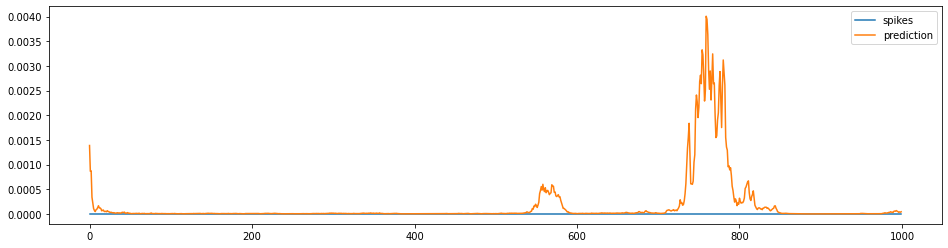

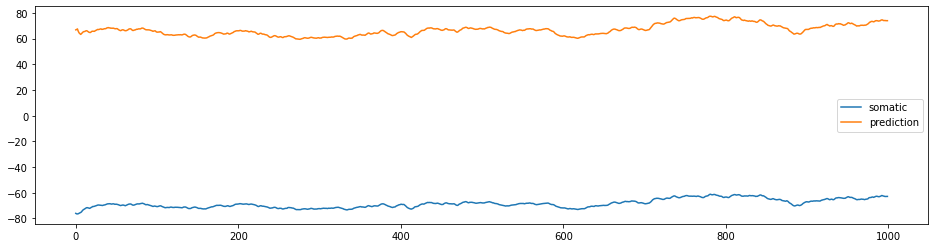

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 512)     1311232     ['layer_1_BN[0][0]']  

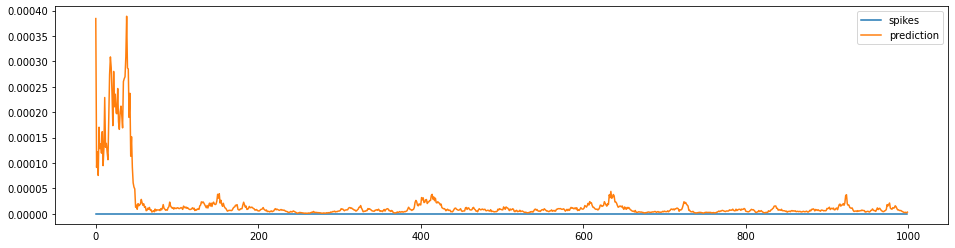

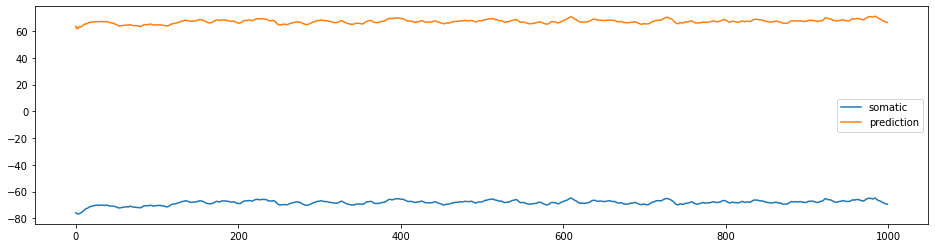

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 512)     1311232     ['layer_1_BN[0][0]']  

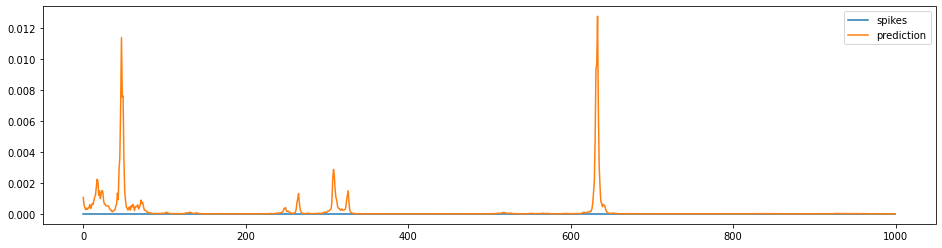

In [ ]:
for X, (spikes, somatic) in list(data_dict.values())[:16]:
    y1, y2 = eval_model(f"./Models/{modelfiles[-1]}", X.T[np.newaxis, :, :],\
                       spikes[np.newaxis, :], somatic[np.newaxis, :], "./test")
    y1 = y1.flatten()
    y2 = y2.flatten()
    
    plt.figure(figsize=(16,4))
    plt.plot(spikes[:1000], label="spikes")
    plt.plot(y1[:1000], label="prediction")
    plt.legend()
    plt.show()
    plt.figure(figsize=(16,4))
    plt.plot(somatic[:1000], label="somatic")
    plt.plot(y2[:1000]-67.7, label="prediction")
    plt.legend()
    plt.show()
    

In [51]:
def calc_AUC_at_desired_FP(y_test, y_test_hat, desired_false_positive_rate=0.01):
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_test_hat.ravel())

    linear_spaced_FPR = np.linspace(0,1,num=20000)
    linear_spaced_TPR = np.interp(linear_spaced_FPR, fpr, tpr)
    
    desired_fp_ind = min(max(1, np.argmin(abs(linear_spaced_FPR - desired_false_positive_rate))), linear_spaced_TPR.shape[0] -1)
    
    return linear_spaced_TPR[:desired_fp_ind].mean()



def calc_TP_at_desired_FP(y_test, y_test_hat, desired_false_positive_rate=0.0025):
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_test_hat.ravel())
    
    desired_fp_ind = np.argmin(abs(fpr - desired_false_positive_rate))
    if desired_fp_ind == 0:
        desired_fp_ind = 1

    return tpr[desired_fp_ind]


def exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat, desired_FP_list=[0.0025,0.0100]):
    
    # evaluate the model and save the results
    print('----------------------------------------------------------------------------------------')
    print('calculating key results...')
    
    evaluation_start_time = time.time()
    
    # store results in the hyper param dict and return it
    evaluations_results_dict = {}
    
    for desired_FP in desired_FP_list:
        TP_at_desired_FP  = calc_TP_at_desired_FP(y_spikes_GT, y_spikes_hat, desired_false_positive_rate=desired_FP)
        AUC_at_desired_FP = calc_AUC_at_desired_FP(y_spikes_GT, y_spikes_hat, desired_false_positive_rate=desired_FP)
        print('-----------------------------------')
        print('TP  at %.4f FP rate = %.4f' %(desired_FP, TP_at_desired_FP))
        print('AUC at %.4f FP rate = %.4f' %(desired_FP, AUC_at_desired_FP))
        TP_key_string = 'TP @ %.4f FP' %(desired_FP)
        evaluations_results_dict[TP_key_string] = TP_at_desired_FP
    
        AUC_key_string = 'AUC @ %.4f FP' %(desired_FP)
        evaluations_results_dict[AUC_key_string] = AUC_at_desired_FP
    
    print('--------------------------------------------------')
    fpr, tpr, thresholds = roc_curve(y_spikes_GT.flatten(), y_spikes_hat.flatten())
    AUC_score = auc(fpr, tpr)
    print('AUC = %.4f' %(AUC_score))
    print('--------------------------------------------------')
    print(np.max(y_soma_GT), np.min(y_soma_GT), np.max(y_soma_hat), np.min(y_soma_hat))
    y_soma_hat[y_soma_hat > np.finfo(np.float64).max] = 0
    y_soma_hat[y_soma_hat < np.finfo(np.float64).min] = 0
    soma_explained_variance_percent = 100.0 * explained_variance_score(y_soma_GT.flatten(),y_soma_hat.flatten())
    soma_RMSE = np.sqrt(MSE(y_soma_GT.ravel(),y_soma_hat.ravel()))
    soma_MAE  = MAE(y_soma_GT.ravel(),y_soma_hat.ravel())
    
    print('--------------------------------------------------')
    print('soma explained_variance percent = %.2f%s' %(soma_explained_variance_percent, '%'))
    print('soma RMSE = %.3f [mV]' %(soma_RMSE))
    print('soma MAE = %.3f [mV]' %(soma_MAE))
    print('--------------------------------------------------')
    
    evaluations_results_dict['AUC'] = AUC_score
    evaluations_results_dict['soma_explained_variance_percent'] = soma_explained_variance_percent
    evaluations_results_dict['soma_RMSE'] = soma_RMSE
    evaluations_results_dict['soma_MAE'] = soma_MAE
    
    evaluation_duration_min = (time.time() - evaluation_start_time) / 60
    print('finished evaluation. time took to evaluate results is %.2f minutes' %(evaluation_duration_min))
    print('----------------------------------------------------------------------------------------')
    
    return evaluations_results_dict

def filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat, desired_FP_list=[0.0025,0.0100],
                                    ignore_time_at_start_ms=500, num_spikes_per_sim=[0,24]):

    time_points_to_eval = np.arange(y_spikes_GT.shape[1]) * (np.arange(y_spikes_GT.shape[1]) >= ignore_time_at_start_ms)
    simulations_to_eval = np.logical_and((y_spikes_GT.sum(axis=1) >= num_spikes_per_sim[0]),(y_spikes_GT.sum(axis=1) <= num_spikes_per_sim[1]))
    
    print('total amount of simualtions is %d' %(y_spikes_GT.shape[0]))
    print('percent of simulations kept = %.2f%s' %(100 * simulations_to_eval.mean(),'%'))
    
    #"""
    print(y_spikes_GT.shape, simulations_to_eval.shape, time_points_to_eval.shape, y_soma_GT.shape)
    y_spikes_GT_to_eval  = y_spikes_GT[simulations_to_eval, :][:, time_points_to_eval]
    y_spikes_hat_to_eval = y_spikes_hat[simulations_to_eval, :][:, time_points_to_eval]
    y_soma_GT_to_eval    = y_soma_GT[simulations_to_eval, :][:, time_points_to_eval]
    y_soma_hat_to_eval   = y_soma_hat[simulations_to_eval, :][:, time_points_to_eval]
    
    return exctract_key_results(y_spikes_GT_to_eval, y_spikes_hat_to_eval, y_soma_GT_to_eval, y_soma_hat_to_eval, desired_FP_list=desired_FP_list)
    #"""
    #return exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat, desired_FP_list=desired_FP_list)
    

def eval_model(model_filename, X_test, y_spike_test, y_soma_test, results_dir):
    temporal_conv_net = keras.models.load_model(model_filename)
    temporal_conv_net.summary()
    
    input_window_size = temporal_conv_net.input_shape[1]

    # load pickle file
    model_metadata_filename = (model_filename.split("__model")[0] + "__training").split('.h5')[0] + '.pickle'
    model_metadata_dict = pickle.load(open(model_metadata_filename, "rb" ), encoding="latin1")
    
    architecture_dict = model_metadata_dict['architecture_dict']
    time_window_T = (np.array(architecture_dict['filter_sizes_per_layer']) - 1).sum() + 1
    overlap_size = min(max(time_window_T + 1, min(150, input_window_size - 50)), 250)

    print('overlap_size = %d' %(overlap_size))
    print('time_window_T = %d' %(time_window_T))
    
    # create spike predictions on test set
    print('predicting using model...')

    prediction_start_time = time.time()
    
    y_train_soma_bias = -67.7
    
    #X_test_for_keras = np.transpose(X_test,axes=[2,1,0])
    X_test_for_keras = X_test
    y1_test_for_keras = y_spike_test
    y2_test_for_keras = y_soma_test - y_train_soma_bias
    print(X_test_for_keras.shape, y1_test_for_keras.shape, y2_test_for_keras.shape)
    
    y1_test_for_keras_hat = np.zeros(y1_test_for_keras.shape)
    y2_test_for_keras_hat = np.zeros(y2_test_for_keras.shape)
    
    num_test_splits = int(2 + (X_test_for_keras.shape[1] - input_window_size) / (input_window_size - overlap_size))
    for i in range(X_test_for_keras.shape[0]):
        print(i)
        for k in range(num_test_splits):
            start_time_ind = k * (input_window_size - overlap_size)
            end_time_ind   = start_time_ind + input_window_size

            curr_X_test_for_keras = X_test_for_keras[i:i+1, start_time_ind:end_time_ind, :]
            
            if curr_X_test_for_keras.shape[1] < input_window_size:
                padding_size = input_window_size - curr_X_test_for_keras.shape[1]
                X_pad = np.zeros((curr_X_test_for_keras.shape[0],padding_size,curr_X_test_for_keras.shape[2]))
                curr_X_test_for_keras = np.hstack((curr_X_test_for_keras,X_pad))

            curr_y1_test_for_keras, curr_y2_test_for_keras, _ = temporal_conv_net.predict(K.constant(curr_X_test_for_keras))
            curr_y1_test_for_keras = K.eval(curr_y1_test_for_keras)
            curr_y2_test_for_keras = K.eval(curr_y2_test_for_keras)

            if k == 0:
                y1_test_for_keras_hat[i,:end_time_ind] = curr_y1_test_for_keras[:, :, 0]
                y2_test_for_keras_hat[i,:end_time_ind] = curr_y2_test_for_keras[:, :, 0]
            elif k == (num_test_splits - 1):
                t0 = start_time_ind + overlap_size
                duration_to_fill = y1_test_for_keras_hat.shape[1] - t0
                y1_test_for_keras_hat[i,t0:] = curr_y1_test_for_keras[:,overlap_size:(overlap_size + duration_to_fill),0]
                y2_test_for_keras_hat[i,t0:] = curr_y2_test_for_keras[:,overlap_size:(overlap_size + duration_to_fill),0]
            else:
                t0 = start_time_ind + overlap_size
                y1_test_for_keras_hat[i,t0:end_time_ind] = curr_y1_test_for_keras[:,overlap_size:,0]
                y2_test_for_keras_hat[i,t0:end_time_ind] = curr_y2_test_for_keras[:,overlap_size:,0]
    
    # zero score the prediction and align it with the actual test
    #s_dst = y2_test_for_keras.std()
    m_dst = y2_test_for_keras.mean()
    s_dst = 0
    for i in y2_test_for_keras.flatten():
        s_dst += (i-m_dst)**2
    s_dst = s_dst/len(y2_test_for_keras.flatten())
    s_dst = np.sqrt(s_dst)
    
    s_src = y2_test_for_keras_hat.std()
    m_src = y2_test_for_keras_hat.mean()
    print(s_src, m_src, s_dst, m_dst)
    #return y1_test_for_keras_hat, y2_test_for_keras_hat
    y2_test_for_keras_hat = (y2_test_for_keras_hat - m_src) / s_src
    y2_test_for_keras_hat = s_dst * y2_test_for_keras_hat + m_dst
    
    
    y_test = y_spike_test
    y_test_hat = y1_test_for_keras_hat
    
    # convert to simple (num_sims X num_time_points) format
    y_spikes_GT  = y_test
    y_spikes_hat = y_test_hat
    y_soma_GT    = y2_test_for_keras
    y_soma_hat   = y2_test_for_keras_hat
    
    print(y_spikes_GT.shape, y_spikes_hat.shape, y_soma_GT.shape, y_soma_hat.shape)
    
    y_spikes_GT  = y_spikes_GT
    y_spikes_hat = y_spikes_hat
    y_soma_GT    = y_soma_GT
    y_soma_hat   = y_soma_hat
    
    prediction_duration_min = (time.time() - prediction_start_time) / 60
    print('finished prediction. time took to predict is %.2f minutes' %(prediction_duration_min))
    # evaluate the model and save the results
    print('calculating and saving key results...')

    saving_start_time = time.time()

    desired_FP_list = [0.0001, 0.0005, 0.0010, 0.0015, 0.0020, 0.0025, 0.0050, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.1000]
    evaluations_results_dict = {}

    # (1) we ignore the first 500 ms so that the simulation will "settle" and forget about any initial conditions
    # (2) we control for the number of spikes per simulation in order to make proper comparisons for different biophysical models (AMPA,NMDA,AMPA_SK, etc.)
    # this is due to the fact the the number of output spikes greatley changes the results and it's important to keep a tight control on it

    ignore_time_at_start_ms = 500
    num_spikes_per_sim = [0,18]
    filter_string = 'starting_at_%dms_spikes_in_[%d,%d]_range' %(ignore_time_at_start_ms, num_spikes_per_sim[0], num_spikes_per_sim[1])
    evaluations_results_dict[filter_string] = filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat,
                                                                              desired_FP_list=desired_FP_list,
                                                                              ignore_time_at_start_ms=ignore_time_at_start_ms,
                                                                              num_spikes_per_sim=num_spikes_per_sim)

    ignore_time_at_start_ms = 500
    num_spikes_per_sim = [1,24]
    filter_string = 'starting_at_%dms_spikes_in_[%d,%d]_range' %(ignore_time_at_start_ms, num_spikes_per_sim[0], num_spikes_per_sim[1])
    evaluations_results_dict[filter_string] = filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat,
                                                                              desired_FP_list=desired_FP_list,
                                                                              ignore_time_at_start_ms=ignore_time_at_start_ms,
                                                                              num_spikes_per_sim=num_spikes_per_sim)

    ignore_time_at_start_ms = 500
    num_spikes_per_sim = [0,24]
    filter_string = 'starting_at_%dms_spikes_in_[%d,%d]_range' %(ignore_time_at_start_ms, num_spikes_per_sim[0], num_spikes_per_sim[1])
    evaluations_results_dict[filter_string] = filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat,
                                                                              desired_FP_list=desired_FP_list,
                                                                              ignore_time_at_start_ms=ignore_time_at_start_ms,
                                                                              num_spikes_per_sim=num_spikes_per_sim)

    ignore_time_at_start_ms = 500
    num_spikes_per_sim = [0,30]
    filter_string = 'starting_at_%dms_spikes_in_[%d,%d]_range' %(ignore_time_at_start_ms, num_spikes_per_sim[0], num_spikes_per_sim[1])
    evaluations_results_dict[filter_string] = filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat,
                                                                              desired_FP_list=desired_FP_list,
                                                                              ignore_time_at_start_ms=ignore_time_at_start_ms,
                                                                              num_spikes_per_sim=num_spikes_per_sim)

    ignore_time_at_start_ms = 500
    num_spikes_per_sim = [0,90]
    filter_string = 'starting_at_%dms_spikes_in_[%d,%d]_range' %(ignore_time_at_start_ms, num_spikes_per_sim[0], num_spikes_per_sim[1])
    evaluations_results_dict[filter_string] = filter_and_exctract_key_results(y_spikes_GT, y_spikes_hat, y_soma_GT, y_soma_hat,
                                                                              desired_FP_list=desired_FP_list,
                                                                              ignore_time_at_start_ms=ignore_time_at_start_ms,
                                                                              num_spikes_per_sim=num_spikes_per_sim)
    
    model_metadata_dict['evaluations_results_dict'] = evaluations_results_dict
    metadata_evaluation_filename = results_dir + model_metadata_filename.split('/')[-1]
    print('saving:   "%s"' %(metadata_evaluation_filename))
    pickle.dump(model_metadata_dict, open(metadata_evaluation_filename, "wb"), protocol=2)
    
    saving_duration_min = (time.time() - saving_start_time) / 60
    print('time took to evaluate and save results is %.3f minutes' %(saving_duration_min))
    print('----------------------------------------------------------------------------------------')

#%%

In [52]:
X = np.concatenate([X.T[np.newaxis, ...] for X, (spikes, soma) in data_dict.values()])
spikes = np.concatenate([spikes[np.newaxis, ...] for X, (spikes, soma) in data_dict.values()])
soma = np.concatenate([soma[np.newaxis, ...] for X, (spikes, soma) in data_dict.values()])

In [57]:
X = X[:16]
spikes = spikes[:16]
soma = soma[:16]

In [56]:
modelfiles

['NMDA_TCN__DWT_7_128_153__model.h5',
 'NMDA_TCN__DWT_7_128_153__training.pickle',
 'NMDA_TCN__DWT_7_292_169__model.h5',
 'NMDA_TCN__DWT_7_292_169__training.pickle',
 'NMDA_TCN__DWT_8_224_217__model.h5',
 'NMDA_TCN__DWT_8_224_217__training.pickle',
 'NMDA_TCN__DWT_9_256_241__model.h5',
 'NMDA_TCN__DWT_9_256_241__training.pickle']

In [54]:
X.shape, spikes.shape, soma.shape

((2, 6000, 1278), (2, 6000), (2, 6000))

In [58]:
eval_model(f"Models/{modelfiles[0]}", X, spikes, soma, "./test")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 400, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 400, 128)     7361408     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 400, 128)    512         ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 400, 128)     311424      ['layer_1_BN[0][0]']       

-----------------------------------
TP  at 0.0100 FP rate = 0.5385
AUC at 0.0100 FP rate = 0.4250
-----------------------------------
TP  at 0.0200 FP rate = 0.8462
AUC at 0.0200 FP rate = 0.5810
-----------------------------------
TP  at 0.0300 FP rate = 0.8462
AUC at 0.0300 FP rate = 0.6950
-----------------------------------
TP  at 0.0400 FP rate = 0.9231
AUC at 0.0400 FP rate = 0.7520
-----------------------------------
TP  at 0.0500 FP rate = 0.9231
AUC at 0.0500 FP rate = 0.7862
-----------------------------------
TP  at 0.1000 FP rate = 1.0000
AUC at 0.1000 FP rate = 0.8585
--------------------------------------------------
AUC = 0.9859
--------------------------------------------------
99.0 -8.31 17.204137093181444 -9.156366476429008
--------------------------------------------------
soma explained_variance percent = 48.37%
soma RMSE = 3.469 [mV]
soma MAE = 1.553 [mV]
--------------------------------------------------
finished evaluation. time took to evaluate results is 0.00 m

In [60]:
eval_model(f"Models/{modelfiles[2]}", X, spikes, soma, "./test")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 256)     917760      ['layer_1_BN[0][0]']       

-----------------------------------
TP  at 0.0010 FP rate = 0.0769
AUC at 0.0010 FP rate = 0.0692
-----------------------------------
TP  at 0.0015 FP rate = 0.0769
AUC at 0.0015 FP rate = 0.0872
-----------------------------------
TP  at 0.0020 FP rate = 0.1538
AUC at 0.0020 FP rate = 0.1038
-----------------------------------
TP  at 0.0025 FP rate = 0.1538
AUC at 0.0025 FP rate = 0.1185
-----------------------------------
TP  at 0.0050 FP rate = 0.3846
AUC at 0.0050 FP rate = 0.2508
-----------------------------------
TP  at 0.0100 FP rate = 0.5385
AUC at 0.0100 FP rate = 0.3923
-----------------------------------
TP  at 0.0200 FP rate = 0.7692
AUC at 0.0200 FP rate = 0.5498
-----------------------------------
TP  at 0.0300 FP rate = 0.8462
AUC at 0.0300 FP rate = 0.6472
-----------------------------------
TP  at 0.0400 FP rate = 0.8462
AUC at 0.0400 FP rate = 0.7129
-----------------------------------
TP  at 0.0500 FP rate = 0.9231
AUC at 0.0500 FP rate = 0.7549
--------------------

In [61]:
eval_model(f"Models/{modelfiles[4]}", X, spikes, soma, "./test")

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 384)     983424      ['layer_1_BN[0][0]']  

TP  at 0.0001 FP rate = 0.0000
AUC at 0.0001 FP rate = 0.0000
-----------------------------------
TP  at 0.0005 FP rate = 0.0000
AUC at 0.0005 FP rate = 0.0154
-----------------------------------
TP  at 0.0010 FP rate = 0.1538
AUC at 0.0010 FP rate = 0.0846
-----------------------------------
TP  at 0.0015 FP rate = 0.2308
AUC at 0.0015 FP rate = 0.1436
-----------------------------------
TP  at 0.0020 FP rate = 0.3077
AUC at 0.0020 FP rate = 0.1846
-----------------------------------
TP  at 0.0025 FP rate = 0.3077
AUC at 0.0025 FP rate = 0.2092
-----------------------------------
TP  at 0.0050 FP rate = 0.3846
AUC at 0.0050 FP rate = 0.2923
-----------------------------------
TP  at 0.0100 FP rate = 0.5385
AUC at 0.0100 FP rate = 0.3896
-----------------------------------
TP  at 0.0200 FP rate = 0.7692
AUC at 0.0200 FP rate = 0.5704
-----------------------------------
TP  at 0.0300 FP rate = 0.8462
AUC at 0.0300 FP rate = 0.6623
-----------------------------------
TP  at 0.0400 FP rat

In [62]:
eval_model(f"Models/{modelfiles[6]}", X, spikes, soma, "./test")

Model: "functional_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 500, 1278)]  0           []                               
                                                                                                  
 layer_1 (Conv1D)               (None, 500, 512)     1963520     ['input_layer[0][0]']            
                                                                                                  
 layer_1_BN (BatchNormalization  (None, 500, 512)    2048        ['layer_1[0][0]']                
 )                                                                                                
                                                                                                  
 layer_2 (Conv1D)               (None, 500, 512)     1311232     ['layer_1_BN[0][0]']  

-----------------------------------
TP  at 0.0005 FP rate = 0.0000
AUC at 0.0005 FP rate = 0.0000
-----------------------------------
TP  at 0.0010 FP rate = 0.0769
AUC at 0.0010 FP rate = 0.0346
-----------------------------------
TP  at 0.0015 FP rate = 0.0769
AUC at 0.0015 FP rate = 0.0641
-----------------------------------
TP  at 0.0020 FP rate = 0.0769
AUC at 0.0020 FP rate = 0.0865
-----------------------------------
TP  at 0.0025 FP rate = 0.0769
AUC at 0.0025 FP rate = 0.1000
-----------------------------------
TP  at 0.0050 FP rate = 0.1538
AUC at 0.0050 FP rate = 0.1392
-----------------------------------
TP  at 0.0100 FP rate = 0.2308
AUC at 0.0100 FP rate = 0.1850
-----------------------------------
TP  at 0.0200 FP rate = 0.6154
AUC at 0.0200 FP rate = 0.3223
-----------------------------------
TP  at 0.0300 FP rate = 0.6923
AUC at 0.0300 FP rate = 0.4456
-----------------------------------
TP  at 0.0400 FP rate = 0.6923
AUC at 0.0400 FP rate = 0.5241
--------------------

In [44]:
datafiles = os.listdir("Data_test")
datafiles = [f"Data_test/{f}" for f in datafiles]
data_dict = extract_relevant_data(load_file(datafiles[11]))
X, (spikes, soma) = data_dict[0]
print(X.shape) 
#eval_model(f"Models/{modelfiles[3]}", X.T[np.newaxis, ...], spikes[np.newaxis, ...], soma[np.newaxis, ...], "./test")

KeyboardInterrupt: 

In [ ]:
np.min(y2), np.max(y2), y2.std(), y1.std()

In [ ]:
plot_predictions("Data_test", ij=(0,1), W=50)

In [ ]:
plot_inputs("Data_test")

In [ ]:
datafiles = [f"./Data_test/{i}" for i in os.listdir("./Data_test")]

In [ ]:
p.keys(), p['Results']['listOfSingleSimulationDicts'][0].keys()

In [ ]:
data_dict = extract_relevant_data(p)

In [ ]:
for i, (X, (spikes, somatic_dendritic)) in data_dict.items():
    

In [ ]:
for k in p['Params']:
    if not isinstance(p['Params'][k], list):
        print(k, p['Params'][k])
    else:
        print(k, len(p['Params'][k]), p['Params'][k][:5])

In [ ]:
spikes, somatic, dendr = np.zeros((6000,)), np.zeros((6000,)), np.zeros(dendritic.shape)
for s in range(0, 5500, 5):
    if s % 100 == 0:
        print(s)
    e = s + 500
    x = X[:, s:e].T
    x = x[np.newaxis, ...]
    y_spikes, y_somatic, y_dendritic = output[s:e], soma[s:e], dendritic[:, s:e]
    they = models[1].call(K.constant(x))
    spikes[s:e] += they[0][0, :, 0]
    somatic[s:e] += they[1][0, :, 0]
    dendr[:, s:e] += they[2][0, :, 0]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(30, 8))
ax[0].plot(output)
ax[0].plot(spikes/10)
ax[1].plot(soma)
ax[1].plot(somatic/10-70)
ax[1].plot([0, 6000], [-25, -25])

In [ ]:
sout.shape, sin.shape, sex.shape, soma.shape

In [ ]:
def plot(s, e, figsize, title, x):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.plot(x[s:e])
    plt.show()
def plot_img(s, e, figsize, title, x):
    plt.figure(figsize=figsize)
    plt.title(title)
    print(x[:, s:e].shape)
    plt.imshow(x[:, s:e])
    plt.show()

In [ ]:
one = np.array([1])
two = np.array([2])
three = np.array([3])
np.concatenate((one, two, three))

In [ ]:
s=10
e = s+500
y_spikes, y_somatic, y_dendritic = \
models[1].predict(X[:, s:e].T[np.newaxis, ...])
plt.figure(figsize=(20,4))
plt.plot(spikes[s:e])
plt.plot(y_spikes[0, :, 0]*10)
plt.plot([0,500],[1,1])
plt.figure(figsize=(20,4))
plt.plot(somatic[s:e] - np.mean(somatic[s:e]))
plt.plot(y_somatic[0, :, 0])
plt.plot([0,500], [0,0])

In [ ]:
X.shape

In [ ]:
interval = 500
thestart = 1000
theend = 1250
cuts = [X[:, i:i+500] for i in range(thestart, theend, interval)]
XS = [i[0] for i in cuts]
ys_predict = [models[1].predict(K.constant(X)) for X in XS]

In [ ]:
all_spikes, all_somatic = np.zeros((theend-thestart+500)), np.zeros((theend-thestart+500))
for i, y_pred in enumerate(ys_predict):
    spikes, somatic, dendritic = y_pred[0][0], y_pred[1][0], K.eval(y_pred[2][0]).T
    all_spikes[i*interval:i*interval+500] += spikes[:, 0]
    all_somatic[i*interval:i*interval+500] += somatic[:, 0]
    #y_spikes, y_somatic, y_dendritic = cuts[i][1]

for i in range():
    
shft = 50
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 8))
ax[0].plot(sout[shft+thestart:theend+500+shft], color="green")
ax[0].plot(all_spikes/6, color="orange")
ax[1].plot(soma[shft+thestart:theend+500+shft], color="green")
ax[1].plot(all_somatic/10-80, color="orange")
plt.show()

"""
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))
dndrt = np.zeros(dendritic.T.shape)
print(dndrt.shape, dndrt[:, 0].shape, dndrt[:, 0].shape)
print(y_dendritic[:, 0].shape, y_dendritic[0].shape)
for i in range(dndrt.shape[1]):
    dndrt[:, i] = np.sum(y_dendritic[i*10:i*10+10, :], axis=0)
ax[0].imshow(dndrt)
ax[1].imshow(dendritic.T*(dendritic.T > 0))
plt.show()
"""

In [ ]:
dendritic.shape, y_dendritic.shape

In [ ]:
dendritic[0][:10], y_dendritic[0][:10]

In [ ]:
os.listdir("./Data_test_OOD")

In [19]:
W = 8

In [35]:
input_layer = keras.layers.Input((1278,W,1))
CL1 = 16
CL2 = 256
d11 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL1,kernel_size=(1,W),activation='sigmoid')(input_layer))
print("d11", d11.shape)
#d21 = keras.layers.BatchNormalization(-1)(\
#        keras.layers.Conv2D(CL1,kernel_size=(1,W))(input_layer))
d12 = keras.layers.Reshape((1278,CL1,1))(d11)
#d22 = keras.layers.Reshape((1278,CL1,1))(d12)
print("d12", d12.shape)
d13 = keras.layers.MaxPool2D((1,4))(d12)
#d23 = keras.layers.MaxPool2D((1,CL1))(d22)
print("d13", d13.shape)
"""
d14 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL2,kernel_size=(4,1))(d13))
d24 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL2,kernel_size=(4,1))(d23))
print("d14", d14.shape)
d15 = keras.layers.MaxPool2D((1275,1),strides=(1,1))(d14)
d25 = keras.layers.MaxPool2D((1275,1), strides=(1,1))(d24)
print(d15.shape)
"""
d16 = keras.layers.Flatten()(d13)
#d26 = keras.layers.Flatten()(d25)
d17 = keras.layers.Dense(256,)(d16)
#d27 = keras.layers.Dense(256,)(d26)
out1 = keras.layers.Dense(1,)(d17)
#out2 = keras.layers.Dense(1,)(d27)
model = keras.models.Model(input_layer, out1)

d11 (None, 1278, 1, 16)
d12 (None, 1278, 16, 1)
d13 (None, 1278, 4, 1)


In [36]:
#model.compile("Adam", loss=[keras.losses.BinaryCrossentropy(), keras.losses.MSE])
#model = keras.models.load_model("./my_first_model.h5")
model.compile("Adam", loss=keras.losses.binary_crossentropy)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1278, 8, 1)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 1278, 1, 16)       144       
                                                                 
 batch_normalization_5 (Batc  (None, 1278, 1, 16)      64        
 hNormalization)                                                 
                                                                 
 reshape_5 (Reshape)         (None, 1278, 16, 1)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1278, 4, 1)       0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 5112)              0   

In [ ]:
time()

In [ ]:
time()

In [54]:
s = time.time()
datafiles = [f"./Data_test/{i}" for i in os.listdir("./Data_test")]
for f, fname in enumerate(datafiles):
    print("\n", f, fname)
    p = load_file(fname)
    sim_dict = extract_relevant_data(p)
    for k in range(1):
        print("k", k, ":")
        for i, (X, (spikes, soma)) in enumerate(list(sim_dict.values())[:32]):
            print(X.shape)
            X = np.array([X.T[i:i+W].T for i in range(X.shape[1]-W)])[:, :, :, np.newaxis]
            y1 = spikes[W:]#np.array(keras.utils.np_utils.to_categorical(spikes, num_classes=2), dtype=np.float32)
            y2 = soma[W:]
            indexes = np.arange(0,len(y1),1)
            ones = indexes[y1==1]
            zeros = indexes[y1==0][:len(ones)*2]
            print(i, X.shape, y1.shape)
            indexes = np.concatenate((ones,zeros))
            print(indexes.shape)
            if len(indexes) != 0:
                model.fit(np.tile(X[indexes],(10,1,1,1)), np.tile(y1[indexes],10), epochs=2, validation_split=0.1)
        acc = []
        for i, (X, (spikes, soma)) in enumerate(list(sim_dict.values())[64:64+16]):
            X = np.array([X.T[i:i+W].T for i in range(X.shape[1]-W)])[:, :, :, np.newaxis]
            y1 = model.predict(X)
            #y1, y2 = model.predict(X)
            a1 = (np.argmax(y1, axis=1)==spikes[W:])[spikes[W:]==1]
            a2 = (np.argmax(y1, axis=1)==spikes[W:])[spikes[W:]==0]
            ac = ((np.sum(a1), np.sum(spikes[W:]==1)), (np.sum(a2), np.sum(spikes[W:]==0)))
            #pr = np.sqrt(np.mean((y1-soma[W:])**2))
            #acc.append((ac, pr))
            print(ac, end=" | ")
        #acc = np.array(acc)
        #print("\n", acc[:, 0].mean(), acc[:, 1].mean())
        e = time.time()
        if e-s > 3600:
            break


 0 ./Data_test/sim__saved_InputSpikes_DVTs__561_outSpikes__128_simulationRuns__6_secDuration__randomSeed_100520.p
k 0 :
(1278, 6000)
0 (5992, 1278, 8, 1) (5992,)
(45,)
Epoch 1/2
13/13 [==============================] - 2s 99ms/step - loss: 3.7705 - val_loss: 5.1416
Epoch 2/2
13/13 [==============================] - 1s 61ms/step - loss: 3.7705 - val_loss: 5.1416
(1278, 6000)
1 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
2 (5992, 1278, 8, 1) (5992,)
(6,)
Epoch 1/2
2/2 [==============================] - 0s 209ms/step - loss: 5.1416 - val_loss: 5.1416
Epoch 2/2
2/2 [==============================] - 0s 115ms/step - loss: 5.1416 - val_loss: 5.1416
(1278, 6000)
3 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
4 (5992, 1278, 8, 1) (5992,)
(21,)
Epoch 1/2
6/6 [==============================] - 1s 88ms/step - loss: 5.1416 - val_loss: 5.1416
Epoch 2/2
6/6 [==============================] - 0s 64ms/step - loss: 5.1416 - val_loss: 5.1416
(1278, 6000)
5 (5992, 1278, 8, 1) (5992,)
(90,)
Epoch 1/2
26

4/4 [==============================] - 0s 84ms/step - loss: 5.1416 - val_loss: 5.1416
Epoch 2/2
4/4 [==============================] - 0s 59ms/step - loss: 5.1416 - val_loss: 5.1416
(1278, 6000)
16 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
17 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
18 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
19 (5992, 1278, 8, 1) (5992,)
(0,)
(1278, 6000)
20 (5992, 1278, 8, 1) (5992,)
(24,)
Epoch 1/2
7/7 [==============================] - 0s 69ms/step - loss: 5.1416 - val_loss: 5.1416
Epoch 2/2
7/7 [==============================] - 0s 58ms/step - loss: 5.1416 - val_loss: 5.1416
(1278, 6000)
21 (5992, 1278, 8, 1) (5992,)
(6,)
Epoch 1/2
2/2 [==============================] - 0s 232ms/step - loss: 5.1416 - val_loss: 5.1416
Epoch 2/2
2/2 [==============================] - 0s 137ms/step - loss: 5.1416 - val_loss: 5.1416
(1278, 6000)
22 (5992, 1278, 8, 1) (5992,)
(48,)
Epoch 1/2
14/14 [==============================] - 1s 63ms/step - loss: 5.1416 - val_loss: 5.1

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x0000022271AA89D0>
Traceback (most recent call last):
  File "C:\Users\Diana\miniconda3\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
model.save("./my_first_dense_model.h5")

In [53]:
np.tile(y1[indexes], 10).shape, np.tile(X[indexes], (10,1,1,1)).shape

((450,), (450, 1278, 8, 1))

In [ ]:
for i, (X, (spikes, soma)) in enumerate(list(sim_dict.values())[16:20]):
    plt.figure(figsize=(20,6))
    plt.imshow(X, cmap='gray_r')
    plt.show()

In [ ]:
np.sqrt(np.mean((model.predict(X)-soma[W:])**2))

In [ ]:
input_layer = keras.layers.Input((1278,W))
CL1 = 16
CL2 = 64
"""
d11 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL1,kernel_size=(1,W))(input_layer))
d21 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL1,kernel_size=(1,W))(input_layer))
"""
d11 = keras.layers.Conv1D(32,kernel_size=5,activation='sigmoid')(input_layer)
#d21 = keras.layers.Conv2D(CL1,kernel_size=(1,W))(input_layer)
print(d11.shape)
#d12 = keras.layers.Reshape((1278,CL1,1))(d11)
#d22 = keras.layers.Reshape((1278,CL1,1))(d12)
#print(d12.shape)
d13 = keras.layers.MaxPool1D(5,)(d11)
print(d13.shape)
d14 = keras.layers.Conv1D(64,kernel_size=4,activation='sigmoid')(d13)
print(d14.shape)
d16 = keras.layers.MaxPool1D(4,)(d14)
print(d16.shape)
#d23 = keras.layers.MaxPool2D((1,4),strides=(1,4))(d22)
d17 = keras.layers.Flatten()(d16)
#d26 = keras.layers.Flatten()(d23)
d18 = keras.layers.Dense(256, activation="sigmoid")(d17)
#d19 = keras.layers.Dense(256, activation="sigmoid")(d18)
#d27 = keras.layers.Dense(256,)(d26)
out1 = keras.layers.Dense(1,)(d18)
#out2 = keras.layers.Dense(1,)(d27)
model = keras.models.Model(input_layer, out1)
"""
print(d13.shape)
d14 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL2,kernel_size=(4,1))(d13))
d24 = keras.layers.BatchNormalization(-1)(\
        keras.layers.Conv2D(CL2,kernel_size=(4,1))(d23))
print(d14.shape)
d15 = keras.layers.MaxPool2D((1275,1),strides=(1,1))(d14)
d25 = keras.layers.MaxPool2D((1275,1), strides=(1,1))(d24)
print(d15.shape)
d16 = keras.layers.Flatten()(d15)
d26 = keras.layers.Flatten()(d25)
d17 = keras.layers.Dense(256,)(d16)
d27 = keras.layers.Dense(256,)(d26)
out1 = keras.layers.Dense(1,)(d17)
out2 = keras.layers.Dense(1,)(d27)
"""
#model = keras.models.Model(input_layer, [out1,out2])

In [ ]:
model.summary()

In [ ]:
np.sum((np.argmax(y1, axis=1)==spikes[W:])[spikes[W:]==0]), np.sum(spikes[W:]==0),\
(np.argmax(y1, axis=1)==spikes[W:])[spikes[W:]==1], np.sum(spikes[W:]==1)

In [ ]:
[i[0] for i in acc], 

In [ ]:
datafiles = [f"./Data_test/{i}" for i in os.listdir("./Data_test")]
for fname in datafiles:
    p = load_file(fname)
    sim_dict = extract_relevant_data(p)
    for X, (spikes, soma) in list(sim_dict.values())[:64]:
        print("hello")
        y1, y2 = model.predict(X.T)
        plt.figure(figsize=(20,4))
        plt.plot(np.argmax(y1, axis=1), linewidth=5)
        plt.plot(spikes, linewidth=2)
        plt.show()

In [ ]:
model.fit(X_train.T, [keras.utils.np_utils.to_categorical(spike_train),soma_train],
          epochs=100)

In [ ]:
plt.plot([0, 100], [1, 5], linewidth=10)

In [ ]:
spikes